Related urls, will remove once finished:
- https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [9]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import sys
import matplotlib.dates as mdates
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model
from shared.lstm import create_data

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date"
target_column = "Close"
df = pd.read_csv(file_path, parse_dates=True)

df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data.shape

(3396, 2)

In [6]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(
    scaled_data,
    n_future=1,
    n_past=30,
    train_test_split_percentage=0.9,
    validation_split_percentage=0,
)

In [6]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(3029, 30, 2)
(337, 30, 2)
(3029, 1)
(337, 1)


In [7]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(
    LSTM(
        units=16,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(
    optimizer=tf.keras.optimizers.Adam(), loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 16)            1216      
                                                                 
 dropout (Dropout)           (None, 30, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3345 (13.07 KB)
Trainable params: 3345 (13.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(
    X_train, y_train, validation_split=0.3, epochs=200, batch_size=64, callbacks=[es]
)

Epoch 1/200


34/34 [==============================] - 9s 88ms/step - loss: 0.2511 - root_mean_squared_error: 0.5011 - val_loss: 1.9605 - val_root_mean_squared_error: 1.4002
Epoch 2/200
34/34 [==============================] - 2s 52ms/step - loss: 0.0290 - root_mean_squared_error: 0.1704 - val_loss: 1.9212 - val_root_mean_squared_error: 1.3861
Epoch 3/200
34/34 [==============================] - 2s 44ms/step - loss: 0.0190 - root_mean_squared_error: 0.1378 - val_loss: 1.8982 - val_root_mean_squared_error: 1.3778
Epoch 4/200
34/34 [==============================] - 2s 55ms/step - loss: 0.0155 - root_mean_squared_error: 0.1246 - val_loss: 1.8681 - val_root_mean_squared_error: 1.3668
Epoch 5/200
34/34 [==============================] - 2s 52ms/step - loss: 0.0142 - root_mean_squared_error: 0.1190 - val_loss: 1.8401 - val_root_mean_squared_error: 1.3565
Epoch 6/200
34/34 [==============================] - 1s 38ms/step - loss: 0.0136 - root_mean_squared_error: 0.1167 - val_loss: 1.8051 - val_root_mean_sq

In [9]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

11/11 [==============================] - 0s 14ms/step - loss: 0.7682 - root_mean_squared_error: 0.8765
test loss, test acc: [0.7682 0.8765]


In [10]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    (
        first_additional_layer,
        second_additional_layer,
        third_additional_layer,
        n_neurons,
        n_batch_size,
        dropout,
    ) = config
    possible_combinations = list(
        itertools.product(
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        )
    )

    print(possible_combinations)
    print("\n")

    hist = []

    for i in range(0, len(possible_combinations)):
        print(f"{i+1}th combination: \n")
        print("--------------------------------------------------------------------")

        (
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        ) = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        # with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(
            LSTM(
                units=n_neurons,
                return_sequences=True,
                input_shape=(x_train.shape[1], x_train.shape[2]),
            )
        )
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation="linear"))
        regressor.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

        es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
        """''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        """ ""

        file_path = "best_model.h5"

        mc = ModelCheckpoint(
            file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
        )

        """''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        """ ""

        regressor.fit(
            x_train,
            y_train,
            validation_split=0.3,
            epochs=1000,
            batch_size=n_batch_size,
            callbacks=[es, mc],
            verbose=0,
        )

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(
            list(
                (
                    first_additional_layer,
                    second_additional_layer,
                    third_additional_layer,
                    n_neurons,
                    n_batch_size,
                    dropout,
                    train_accuracy,
                    test_accuracy,
                )
            )
        )

        print(
            f"{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}"
        )

    return hist

In [11]:
config = [
    [True, False],
    [True, False],
    [True, False],
    [64, 128, 256],
    [7, 28,365],
    [0.2],
]

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(
    config, X_train, y_train, X_test, y_test
)  # change x_train shape

[(True, True, True, 64, 7, 0.2), (True, True, True, 64, 28, 0.2), (True, True, True, 64, 365, 0.2), (True, True, True, 128, 7, 0.2), (True, True, True, 128, 28, 0.2), (True, True, True, 128, 365, 0.2), (True, True, True, 256, 7, 0.2), (True, True, True, 256, 28, 0.2), (True, True, True, 256, 365, 0.2), (True, True, False, 64, 7, 0.2), (True, True, False, 64, 28, 0.2), (True, True, False, 64, 365, 0.2), (True, True, False, 128, 7, 0.2), (True, True, False, 128, 28, 0.2), (True, True, False, 128, 365, 0.2), (True, True, False, 256, 7, 0.2), (True, True, False, 256, 28, 0.2), (True, True, False, 256, 365, 0.2), (True, False, True, 64, 7, 0.2), (True, False, True, 64, 28, 0.2), (True, False, True, 64, 365, 0.2), (True, False, True, 128, 7, 0.2), (True, False, True, 128, 28, 0.2), (True, False, True, 128, 365, 0.2), (True, False, True, 256, 7, 0.2), (True, False, True, 256, 28, 0.2), (True, False, True, 256, 365, 0.2), (True, False, False, 64, 7, 0.2), (True, False, False, 64, 28, 0.2), (Tr


Epoch 1: val_loss improved from inf to 0.98610, saving model to best_model.h5


/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.98610 to 0.91106, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.91106

Epoch 4: val_loss did not improve from 0.91106

Epoch 5: val_loss did not improve from 0.91106

Epoch 6: val_loss did not improve from 0.91106

Epoch 7: val_loss did not improve from 0.91106
Epoch 7: early stopping
0-th combination = (True, True, True, 64, 7, 0.2) 
 train accuracy: [0.5017463564872742, 0.708340585231781] and test accuracy: [0.8513628840446472, 0.9226932525634766]
2th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 1.16217, saving model to best_model.h5

Epoch 2: val_loss did not improve from 1.16217

Epoch 3: val_loss did not improve from 1.16217

Epoch 4: val_loss did not improve from 1.16217

Epoch 5: val_loss did not improve from 1.16217

Epoch 6: val_loss did not improve from 1.16217
Epoch 6: early stopping
1-th combination = (True, True, True, 64, 28, 0.2) 
 t

In [12]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
71,False,False,False,256,365,0.2,"[0.012978555634617805, 0.11392346024513245]","[0.00913596898317337, 0.0955822616815567]"
62,False,False,True,256,365,0.2,"[0.014666862785816193, 0.1211068257689476]","[0.010346831753849983, 0.10171937942504883]"
35,True,False,False,256,365,0.2,"[0.033113993704319, 0.18197250366210938]","[0.02119331806898117, 0.1455792486667633]"
70,False,False,False,256,28,0.2,"[0.028091616928577423, 0.16760553419589996]","[0.02491089515388012, 0.15783186256885529]"
53,False,True,False,256,365,0.2,"[0.03401005268096924, 0.18441814184188843]","[0.02544267848134041, 0.159507617354393]"
...,...,...,...,...,...,...,...,...
45,False,True,False,64,7,0.2,"[0.48930731415748596, 0.6995050311088562]","[0.7227279543876648, 0.8501340746879578]"
9,True,True,False,64,7,0.2,"[0.4566420614719391, 0.6757529377937317]","[0.7539973258972168, 0.868330180644989]"
15,True,True,False,256,7,0.2,"[0.502824604511261, 0.7091012597084045]","[0.8482761979103088, 0.9210191369056702]"
0,True,True,True,64,7,0.2,"[0.5017463564872742, 0.708340585231781]","[0.8513628840446472, 0.9226932525634766]"


In [13]:
print(
    f"Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}"
)
print("**************************")
print(f"Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n")
print(f"Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n")
print(
    f"{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement"
)

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 256
 n_batch_size = 365
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.8765

Results After Tunning:
 Test Set RMSE: 0.0956

89.0% Improvement


In [14]:
(
    first_additional_layer,
    second_additional_layer,
    third_additional_layer,
    n_neurons,
    n_batch_size,
    dropout,
) = list(hist.iloc[0, :-2])

In [15]:
regressor = Sequential()
regressor.add(
    LSTM(
        units=n_neurons,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

file_path = "best_model.h5"

mc = ModelCheckpoint(
    file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
)

regressor.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=n_batch_size,
    callbacks=[es, mc],
    verbose=0,
)


Epoch 1: val_loss improved from inf to 0.61707, saving model to best_model.h5


/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.61707 to 0.11909, saving model to best_model.h5

Epoch 3: val_loss improved from 0.11909 to 0.11402, saving model to best_model.h5

Epoch 4: val_loss improved from 0.11402 to 0.10899, saving model to best_model.h5

Epoch 5: val_loss improved from 0.10899 to 0.07427, saving model to best_model.h5

Epoch 6: val_loss improved from 0.07427 to 0.06631, saving model to best_model.h5

Epoch 7: val_loss improved from 0.06631 to 0.05341, saving model to best_model.h5

Epoch 8: val_loss improved from 0.05341 to 0.04540, saving model to best_model.h5

Epoch 9: val_loss improved from 0.04540 to 0.04236, saving model to best_model.h5

Epoch 10: val_loss improved from 0.04236 to 0.03547, saving model to best_model.h5

Epoch 11: val_loss improved from 0.03547 to 0.03292, saving model to best_model.h5

Epoch 12: val_loss improved from 0.03292 to 0.03127, saving model to best_model.h5

Epoch 13: val_loss improved from 0.03127 to 0.03092, saving model to best_model.h5


In [16]:
regressor.evaluate(X_test, y_test)

11/11 [==============================] - 1s 66ms/step - loss: 0.0087


0.008658326230943203

In [8]:
y_pred = regressor.predict(X_test)

11/11 [==============================] - 1s 21ms/step


11/11 [==============================] - 0s 21ms/step


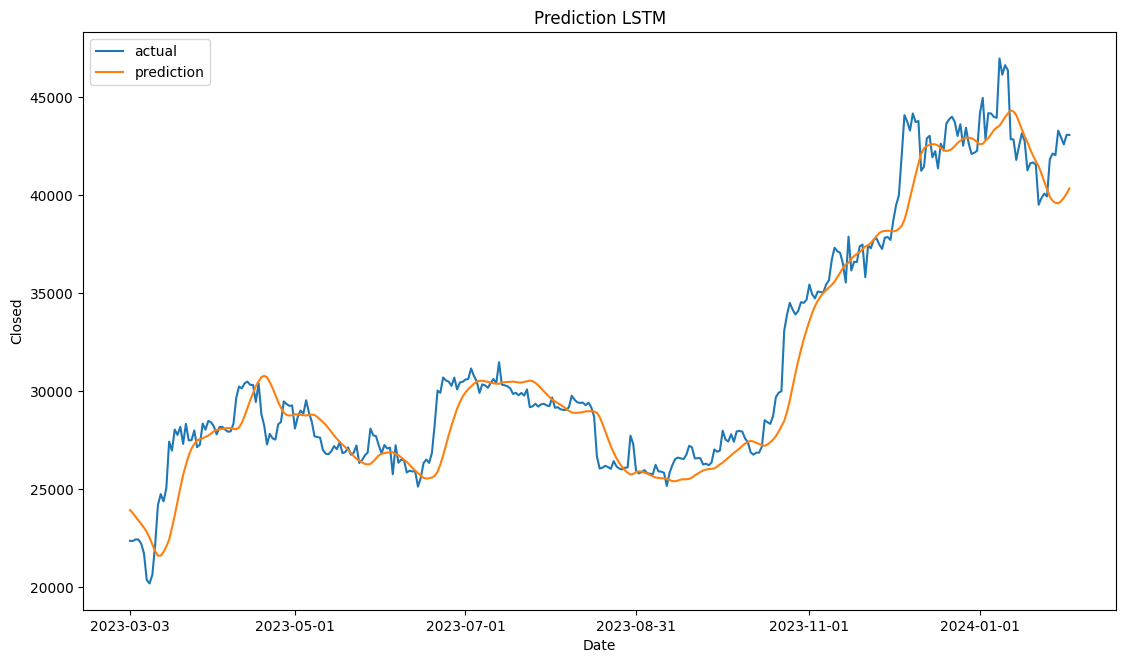

In [11]:
scaler = StandardScaler()
scaler.fit(df[[target_column]])
y_pred = regressor.predict(X_test)
unscaled_y_pred = scaler.inverse_transform([y_pred.flatten()])[0]
unscaled_y_test = scaler.inverse_transform([y_test.flatten()])[0]
unscaled_y_train = scaler.inverse_transform([y_train.flatten()])[0]

data_length = len(unscaled_y_test)

fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(dates[-data_length:], unscaled_y_test, label="actual")
ax.plot(dates[-data_length:], unscaled_y_pred, label="prediction")
ax.set_title("Prediction LSTM")
ax.set_ylabel("Closed")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [12]:
print_evaluation_metrics(unscaled_y_pred, unscaled_y_test, unscaled_y_train)

Evaluation Metrics:
MSE: 2317645.61
RMSE: 1522.38
MAE: 1084.63
MAPE: 3.46
SMAPE: 3.52
MASE: 2.98


In [12]:
store_model(regressor, "lstm")